## ANLY561 Project 
## Team 1
## Image Denoise

#### Code for EDA and PCA


PART 1


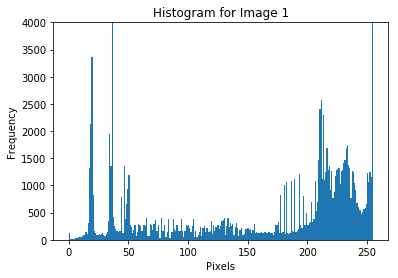

/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


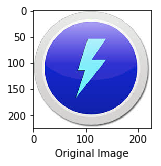


PCA Results:


Variance retained 82.17642013975323 %
Compression Ratio 0.7407407407407408 %


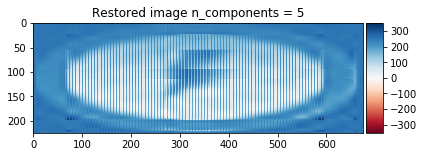



Variance retained 96.0766393508565 %
Compression Ratio 3.7037037037037033 %


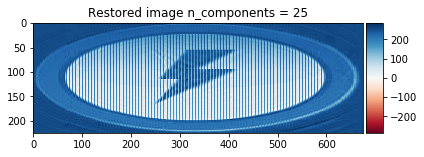



Variance retained 99.20030938459577 %
Compression Ratio 18.51851851851852 %


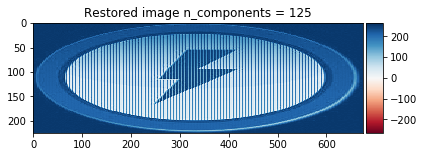



PART2



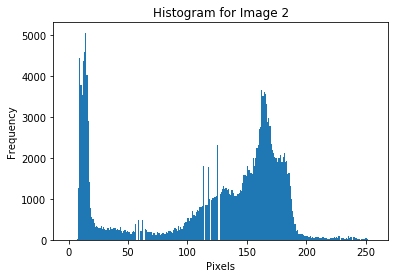

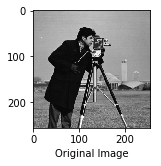


PCA Results:


Variance retained 85.04292889050966 %
Compression Ratio 0.6510416666666667 %


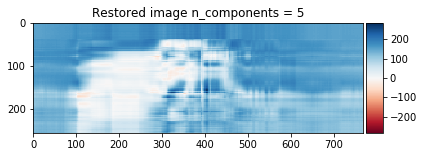



Variance retained 96.24201727897822 %
Compression Ratio 3.2552083333333335 %


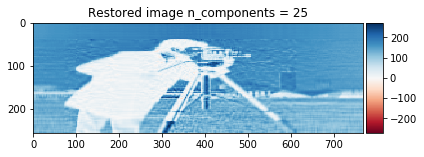



Variance retained 99.20110014670243 %
Compression Ratio 16.276041666666664 %


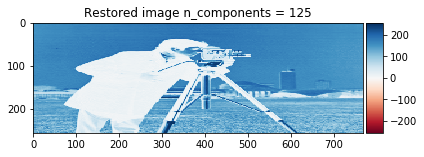

In [4]:
#### ANLY561 Project
#### Heng Zhou, Hongyang Zheng, Prerna Kaul, Xinyi Ye
#### Image Denoise 


# Import libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from pylab import *
from skimage import data, io, color
import numpy.linalg as la
import numpy.random as rd
import scipy.sparse as sparse
import scipy.sparse.linalg as spla
from skimage.restoration import (denoise_tv_chambolle, denoise_tv_bregman, denoise_bilateral,denoise_wavelet, estimate_sigma)
from skimage import img_as_float
from skimage.util import random_noise


# =============================================================================
# 
# ################################### PART 1 ##################################
# 
# =============================================================================

print("\nPART 1")

################# Histogram #############

# Read image
image1=cv2.imread('img_part1.jpg')

# Show image
#io.imshow(image1)

# Plotting histogram for grayscale images
hist = cv2.calcHist([image1],[0],None,[255],[0,255])
plt.hist(image1.ravel(),255,[0,255])
plt.title('Histogram for Image 1')
axes = plt.gca()
axes.set_ylim([0,4000])
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()

################## PCA #################

subplot(2, 2, 1)
io.imshow(image1)
xlabel('Original Image')
plt.show()

# Reshape the data from 3D to 2D
nsamples, nx, ny = image1.shape
image_dataset = image1.reshape((nsamples,nx*ny))

print("\nPCA Results:")

# PCA for different components
for i in range(1, 4):
    n_comp = 5 ** i
    pca = PCA(n_components = n_comp)
    pca.fit(image_dataset)
    image_pca = pca.fit_transform(image_dataset)
    
    image_restored = pca.inverse_transform(image_pca)
    
    figure(figsize = (11,11))
    subplot(2, 2, i+1)
    title('Restored image n_components = %s' %n_comp)
    io.imshow(image_restored)
    print('\n\nVariance retained %s %%' %((1 - sum(pca.explained_variance_ratio_) / size(pca.explained_variance_ratio_)) * 100))
    print('Compression Ratio %s %%' %(float(size(image_pca)) / size(image_dataset) * 100))
    show()

    
# =============================================================================
# 
# #################################### PART 2 #################################
# 
# =============================================================================

print("\n\nPART2\n")

################# Histogram #############

# Read image
image1=cv2.imread('img_part2.png')

# Show image
#io.imshow(image1)

# Plotting histogram for grayscale images
hist = cv2.calcHist([image1],[0],None,[256],[0,256])
plt.hist(image1.ravel(),256,[0,256])
plt.title('Histogram for Image 2')
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.show()

################## PCA #################

subplot(2, 2, 1)
io.imshow(image1)
xlabel('Original Image')
plt.show()

# Reshape the data from 3D to 2D
nsamples, nx, ny = image1.shape
image_dataset = image1.reshape((nsamples,nx*ny))

print("\nPCA Results:")

# PCA for different components
for i in range(1, 4):
    n_comp = 5 ** i
    pca = PCA(n_components = n_comp)
    pca.fit(image_dataset)
    image_pca = pca.fit_transform(image_dataset)
    
    image_restored = pca.inverse_transform(image_pca)
    
    figure(figsize = (11,11))
    subplot(2, 2, i+1)
    title('Restored image n_components = %s' %n_comp)
    io.imshow(image_restored)
    print('\n\nVariance retained %s %%' %((1 - sum(pca.explained_variance_ratio_) / size(pca.explained_variance_ratio_)) * 100))
    print('Compression Ratio %s %%' %(float(size(image_pca)) / size(image_dataset) * 100))
    show()

#### Code for using total variance minimization to denoise image

In [5]:
def shrink(x,l):
    '''
    Soft thresholding function
    :param x: numpy array to be threshholded
    :param l: threshold parameter
    :return: numpy array the same shape as x
    '''
    y = np.abs(x)-l
    y[y<0] = 0
    return np.sign(x)*y

def sparse_discrete_diff(n):
    '''
    Sparse discrete difference matrix on a grid
    :param n: for the n by n grid
    :return: sparse discrete difference matrix
    '''
    d = sparse.diags([-1, 1], [0, 1], shape = (n-1, n))
    id = sparse.identity(n)
    return sparse.vstack([sparse.kron(d,id), sparse.kron(id,d)])

def TV_min(res, x, lam=1e-1, gam=1e1, iter = int(1e3)):
    '''
    Perform TV minimization
    :param res: resolution of square image
    :param x: grayscale image as a numpy array
    :param lam: sparsity term
    :param gam: fidelity term
    :param iter: number of iterations to employ
    :return: TV regularized image 
    '''
    
    D = sparse_discrete_diff(res)
    A = gam * D.T @ D + sparse.identity(res**2)
    lam_gam = lam / gam
    q = np.zeros(D.shape[0])
    b = np.zeros(q.shape)
    h = x

    for i in range(iter):
        z=h + (gam * (D.T @ (q-b)))
        phi = spla.spsolve(A, h + gam * (D.T @ (q-b)))
        q = shrink(b + (D @ phi), lam_gam)
        b = b + (D @ phi) - q
        if i % (iter/10) == 0:
            err = np.sqrt(np.sum((phi - x) ** 2))
            tv = np.sum(np.abs(D@phi))
            i1.append(i)
            err1.append(err)
            tv1.append(tv)
            print('Bregman iteration: %d Error %f TV %f' % (i, err, tv))

    return phi

# Convert image to one dimentional array
img = Image.open('img_part1.jpg').convert('1')  
arr = np.array(img)
original=arr
err1=[]
tv1=[]
i1=[]

n = 225
#x = np.reshape(original, (n**2,)) + 0.1*rd.randn(n**2) # Vectorize and add noise
x = np.reshape(original, (n**2,))
x_tv = TV_min(n, x, lam=0.2)

plt.subplot(1,3,1)
#plt.imshow(img, clim=(-0.2,1), cmap='gray')
plt.imshow(img)
plt.axis('off')
plt.savefig('_img1.png')
plt.title('Original')
plt.subplot(1,3,2)
plt.imshow(np.reshape(x, (n,n)), clim=(-0.2,1), cmap='gray')
plt.axis('off')
plt.title('Noisy')
plt.subplot(1,3,3)
plt.imshow(np.reshape(x_tv, (n,n)), clim=(-0.2,1), cmap='gray')
plt.axis('off')
plt.savefig('tved_img1.png')
plt.title('Denoised')
plt.show()

df=pd.DataFrame({'x': i1,
                 'y1':err1,
                 'y2':tv1})
 
# multiple line plot
plt.figure(figsize=(8, 2))
plt.subplot(1,2,1)
plt.title('Bregman Iteration Error')
plt.xlabel('Iteration')
plt.plot( 'x', 'y1', data=df, color='skyblue', linewidth=2)
plt.subplot(1,2,2)
plt.xlabel('Iteration')
plt.plot( 'x', 'y2', data=df, marker='', color='red', linewidth=2)
plt.title('Bregman Iteration Total Variance')

Bregman iteration: 0 Error 82.325074 TV 1191.621498
Bregman iteration: 100 Error 79.827591 TV 1519.670853


KeyboardInterrupt: 

#### Code for comparing three methods

/anaconda3/lib/python3.6/site-packages/pywt/_multilevel.py:408: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return a_coeff[[slice(s) for s in d_coeff.shape]]
/anaconda3/lib/python3.6/site-packages/skimage/restoration/_denoise.py:478: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return pywt.waverecn(denoised_coeffs, wavelet)[original_extent]


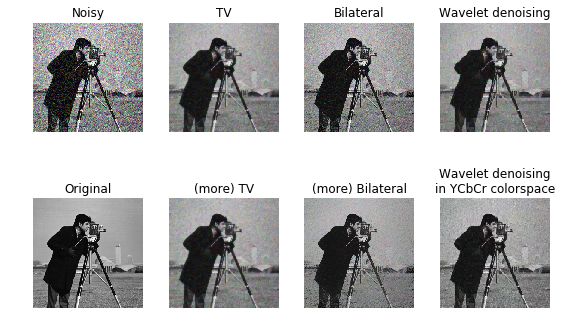

MSE of noisy = 0.06286867418228059
MSE of TV = 0.011994289870473837
MSE of BT = 0.021125293911152525
MSE of WT = 0.014044602222406624
MSE of TV2 = 0.011689453874181651
MSE of BT2 = 0.011459146281612353
MSE of WT2 = 0.009346571390205867
Estimated Gaussian noise standard deviation of noisy = 0.1423292179009429
Estimated Gaussian noise standard deviation of TV= 0.013007329412018473
Estimated Gaussian noise standard deviation of BT= 0.07616838848187545
Estimated Gaussian noise standard deviation of WT= 0.004852562676755954
Estimated Gaussian noise standard deviation of TV2= 0.009328816722002737
Estimated Gaussian noise standard deviation of BT2= 0.03673263844830136
Estimated Gaussian noise standard deviation of WT2= 0.009043135697271115


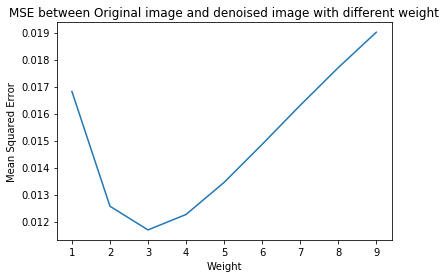

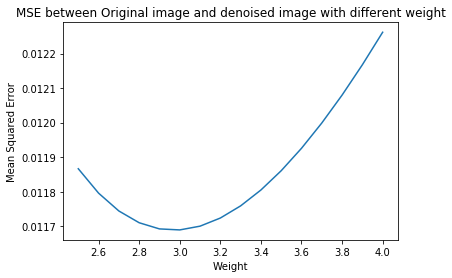

In [7]:
# Load image
image=cv2.imread('img_part2.png')

# Convert data type uint8 into float64
original = img_as_float(image)

# Set noise
sigma = 0.155
noisy = random_noise(original, var=sigma**2)

# Set the format of plots
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(8, 5),sharex=True, sharey=True)
plt.gray()


# Function to compare denoising image and original image 
def mse(imageA, imageB):
    # the 'Mean Squared Error' between the two images is the
    # sum of the squared difference between the two images;
    # NOTE: the two images must have the same dimension
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    
    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


# Show the noisy plot
ax[0, 0].imshow(noisy)
ax[0, 0].axis('off')
ax[0, 0].set_title('Noisy')

# Show denoised plots after three methods
TV = denoise_tv_bregman(noisy, weight=3.0, eps=0.02)
ax[0, 1].imshow(TV)
ax[0, 1].axis('off')
ax[0, 1].set_title('TV')

BT = denoise_bilateral(noisy, sigma_color=0.05, sigma_spatial=15,multichannel=True)
ax[0, 2].imshow(BT)
ax[0, 2].axis('off')
ax[0, 2].set_title('Bilateral')

WT = denoise_wavelet(noisy, multichannel=True)
ax[0, 3].imshow(WT)
ax[0, 3].axis('off')
ax[0, 3].set_title('Wavelet denoising')

# Change paremeters of each method, show plots
TV2 = denoise_tv_bregman(noisy, weight=3.0, eps=0.01)
ax[1, 1].imshow(TV2)
ax[1, 1].axis('off')
ax[1, 1].set_title('(more) TV')

BT2 = denoise_bilateral(noisy, sigma_color=0.1, sigma_spatial=15,multichannel=True)
ax[1, 2].imshow(BT2)
ax[1, 2].axis('off')
ax[1, 2].set_title('(more) Bilateral')

WT2 = denoise_wavelet(noisy, multichannel=True, convert2ycbcr=True)
ax[1, 3].imshow(WT2)
ax[1, 3].axis('off')
ax[1, 3].set_title('Wavelet denoising\nin YCbCr colorspace')

# Show original plot
ax[1, 0].imshow(original)
ax[1, 0].axis('off')
ax[1, 0].set_title('Original')

fig.tight_layout()

plt.show()

# Evaluate denoising performance for each method at each level
# Calculating MSE error between denoised plot and original plot
print('MSE of noisy = {}'.format(mse(noisy, original)))
print('MSE of TV = {}'.format(mse(TV,original)))
print('MSE of BT = {}'.format(mse(BT,original)))
print('MSE of WT = {}'.format(mse(WT,original)))
print('MSE of TV2 = {}'.format(mse(TV2, original)))
print('MSE of BT2 = {}'.format(mse(BT2, original)))
print('MSE of WT2 = {}'.format(mse(WT2, original)))

# Estimate the average noise standard deviation across color channels of each plot
sigma_est_noisy = estimate_sigma(noisy, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of noisy = {}".format(sigma_est_noisy))

sigma_est_tv = estimate_sigma(TV, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of TV= {}".format(sigma_est_tv))

sigma_est_bt = estimate_sigma(BT, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of BT= {}".format(sigma_est_bt))

sigma_est_wt = estimate_sigma(WT, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of WT= {}".format(sigma_est_wt))

sigma_est_tv2 = estimate_sigma(TV2, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of TV2= {}".format(sigma_est_tv2))

sigma_est_bt2 = estimate_sigma(BT2, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of BT2= {}".format(sigma_est_bt2))

sigma_est_wt2 = estimate_sigma(WT2, multichannel=True, average_sigmas=True)
print("Estimated Gaussian noise standard deviation of WT2= {}".format(sigma_est_wt2))


# Process for finding optimal weight
# Store MSE score for weight from 1 to 10 
tv_score1=[]
for i in range(1,10,1):
    denoise=denoise_tv_bregman(noisy, weight=i, eps=0.01)
    tv_score1.append(mse(original,denoise))
    
# Plot for the first try
x1 = range(1,10,1)
y1= tv_score1

plt.plot(x1,y1)
plt.xlabel('Weight')
plt.ylabel('Mean Squared Error')
plt.title('MSE between Original image and denoised image with different weight')
plt.show()
    
# Store MSE score for weight from 2.5 to 4.0    
tv_score2=[]
for j in (2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4):
    denoise=denoise_tv_bregman(noisy, weight=j, eps=0.01)
    tv_score2.append(mse(original,denoise))    

# Plot for the second try
x2 = (2.5,2.6,2.7,2.8,2.9,3,3.1,3.2,3.3,3.4,3.5,3.6,3.7,3.8,3.9,4)
y2= tv_score2

plt.plot(x2,y2)
plt.xlabel('Weight')
plt.ylabel('Mean Squared Error')
plt.title('MSE between Original image and denoised image with different weight')
plt.show()